# Benchmark perturbation prediction

notebook for benchmarking perturbation prediction

## Library imports

In [1]:
import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

import scanpy as sc
import scvelo as scv
import scvi

from rgv_tools import DATA_DIR, FIG_DIR
from rgv_tools.benchmarking import perturb_prediction
from rgv_tools.core import METHOD_PALETTE_PERTURBATION

/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_t

## General setting

In [2]:
scvi.settings.seed = 0

[rank: 0] Seed set to 0


In [3]:
DATASET = "zebrafish"

In [4]:
SAVE_FIGURES = True
if SAVE_FIGURES:
    (FIG_DIR / DATASET / "results").mkdir(parents=True, exist_ok=True)

## Constant

In [5]:
single_ko = ["rarga", "rxraa", "nr2f5", "fli1a", "tfec", "elk3", "mitfa", "ets1", "nr2f2", "elf1", "ebf3a"]
multiple_ko = ["fli1a_elk3", "tfec_mitfa_bhlhe40", "mitfa_tfec", "mitfa_tfec_tfeb"]

In [6]:
terminal_states = ["mNC_arch2", "mNC_head_mesenchymal", "mNC_hox34", "Pigment"]

In [7]:
METHODS = ["RegVelo", "Dynamo (KO)", "Dynamo (perturbation)", "celloracle"]

In [8]:
GENE_MARKER = {
    "rarga": "",
    "rxraa": "o",
    "nr2f5": "o",
    "fli1a": "o",
    "tfec": "o",
    "elk3": "",
    "mitfa": "o",
    "ets1": "X",
    "nr2f2": (4, 0, 45),
    "elf1": "P",
    "ebf3a": (4, 0, 0),
    "fli1a_elk3": (4, 1, 0),
    "tfec_mitfa_bhlhe40": "^",
    "mitfa_tfec": (4, 1, 45),
    "mitfa_tfec_tfeb": "v",
}

## Data loading

### Perturbation predicton

In [9]:
perturbation = pd.read_csv(DATA_DIR / DATASET / "results" / "MELD_median_score.csv", index_col=0)

In [10]:
TERMINAL_STATES_KO = perturbation.columns.tolist()
TERMINAL_STATES_PERTURB = perturbation.columns.tolist()

In [11]:
TERMINAL_STATES_PERTURB[3] = "Pigment"
TERMINAL_STATES_KO[3] = "Pigment_gch2"

### Single knock-out panel prediction results

In [12]:
coef_perturb_co = pd.read_csv(DATA_DIR / DATASET / "results" / "celloracle_perturb_single.csv", index_col=0)
coef_perturb_dyn = pd.read_csv(DATA_DIR / DATASET / "results" / "dynamo_perturb_single.csv", index_col=0)
coef_KO_dyn = pd.read_csv(DATA_DIR / DATASET / "results" / "dynamo_KO_single.csv", index_col=0)

In [13]:
coef_perturb_co = coef_perturb_co.loc[single_ko, TERMINAL_STATES_PERTURB]
coef_perturb_dyn = coef_perturb_dyn.loc[single_ko, TERMINAL_STATES_PERTURB]
coef_KO_dyn = coef_KO_dyn.loc[single_ko, TERMINAL_STATES_KO]

In [14]:
single_matrix = perturbation.loc[single_ko, :]

In [15]:
score_s = []
method = []

score_s.append(scipy.stats.spearmanr(np.array(single_matrix).reshape(-1), np.array(1 - coef_perturb_co).reshape(-1))[0])
method.append("celloracle")

score_s.append(scipy.stats.spearmanr(np.array(single_matrix).reshape(-1), np.array(coef_perturb_dyn).reshape(-1))[0])
method.append("Dynamo (perturbation)")

score_s.append(scipy.stats.spearmanr(np.array(single_matrix).reshape(-1), np.array(coef_KO_dyn).reshape(-1))[0])
method.append("Dynamo (KO)")

In [16]:
for nrun in range(3):
    coef_perturb_rgv = pd.read_csv(
        DATA_DIR / DATASET / "results" / ("runs" + str(nrun + 1)) / "regvelo_single.csv", index_col=0
    )

    coef_perturb_rgv = coef_perturb_rgv.loc[single_ko, TERMINAL_STATES_KO]
    score_s.append(
        scipy.stats.spearmanr(np.array(single_matrix).reshape(-1), np.array(coef_perturb_rgv).reshape(-1))[0]
    )
    method.append("RegVelo")

### Add multiple knock-out panel prediction results

In [17]:
coef_perturb_co = pd.read_csv(DATA_DIR / DATASET / "results" / "celloracle_perturb_single.csv", index_col=0)
coef_perturb_dyn = pd.read_csv(DATA_DIR / DATASET / "results" / "dynamo_perturb_single.csv", index_col=0)
coef_KO_dyn = pd.read_csv(DATA_DIR / DATASET / "results" / "dynamo_KO_single.csv", index_col=0)

In [18]:
coef_perturb_co2 = pd.read_csv(DATA_DIR / DATASET / "results" / "celloracle_perturb_multiple.csv", index_col=0)
coef_perturb_dyn2 = pd.read_csv(DATA_DIR / DATASET / "results" / "dynamo_perturb_multiple.csv", index_col=0)
coef_KO_dyn2 = pd.read_csv(DATA_DIR / DATASET / "results" / "dynamo_KO_multiple.csv", index_col=0)

In [19]:
coef_perturb_co = pd.concat([coef_perturb_co, coef_perturb_co2])
coef_perturb_dyn = pd.concat([coef_perturb_dyn, coef_perturb_dyn2])
coef_KO_dyn = pd.concat([coef_KO_dyn, coef_KO_dyn2])

In [20]:
coef_perturb_co = coef_perturb_co.loc[single_ko + multiple_ko, TERMINAL_STATES_PERTURB]
coef_perturb_dyn = coef_perturb_dyn.loc[single_ko + multiple_ko, TERMINAL_STATES_PERTURB]
coef_KO_dyn = coef_KO_dyn.loc[single_ko + multiple_ko, TERMINAL_STATES_KO]

In [21]:
single_matrix = perturbation.loc[single_ko + multiple_ko, :]

In [22]:
score_m = []
method = []

score_m.append(scipy.stats.spearmanr(np.array(single_matrix).reshape(-1), np.array(1 - coef_perturb_co).reshape(-1))[0])
method.append("celloracle")

score_m.append(scipy.stats.spearmanr(np.array(single_matrix).reshape(-1), np.array(coef_perturb_dyn).reshape(-1))[0])
method.append("Dynamo (perturbation)")

score_m.append(scipy.stats.spearmanr(np.array(single_matrix).reshape(-1), np.array(coef_KO_dyn).reshape(-1))[0])
method.append("Dynamo (KO)")

In [23]:
for nrun in range(3):
    coef_perturb_rgv = pd.read_csv(
        DATA_DIR / DATASET / "results" / ("runs" + str(nrun + 1)) / "regvelo_single.csv", index_col=0
    )
    coef_perturb_rgv2 = pd.read_csv(
        DATA_DIR / DATASET / "results" / ("runs" + str(nrun + 1)) / "regvelo_multiple.csv", index_col=0
    )
    coef_perturb_rgv = pd.concat([coef_perturb_rgv, coef_perturb_rgv2])

    coef_perturb_rgv = coef_perturb_rgv.loc[single_ko + multiple_ko, TERMINAL_STATES_KO]
    score_m.append(
        scipy.stats.spearmanr(np.array(single_matrix).reshape(-1), np.array(coef_perturb_rgv).reshape(-1))[0]
    )
    method.append("RegVelo")

## Plot comparsion

In [24]:
dat = pd.DataFrame({"Spearman_correlation": score_s, "method": method})
dat2 = pd.DataFrame({"Spearman_correlation": score_m, "method": method})
dat["Experimental class"] = "Single TF knock-out"
dat2["Experimental class"] = "Single + Multiple TF knock-out"
df = pd.concat([dat, dat2], axis=0)

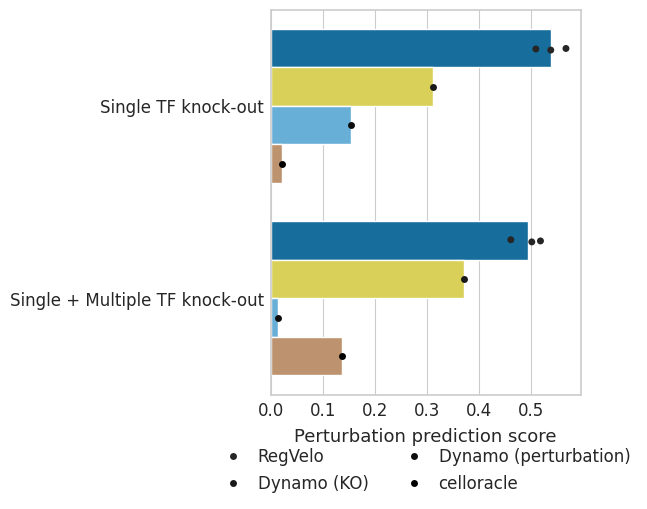

In [25]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(4, 5))

    # Plot the barplot without error bars
    sns.barplot(
        data=df,
        y="Experimental class",
        x="Spearman_correlation",
        hue="method",
        hue_order=METHODS,
        palette=METHOD_PALETTE_PERTURBATION,
        ax=ax,
        ci=None,
    )

    # Add jittered dots
    sns.stripplot(
        data=df,
        y="Experimental class",
        x="Spearman_correlation",
        hue="method",
        hue_order=METHODS,
        dodge=True,
        color="black",
        ax=ax,
        jitter=True,
    )

    # Remove the duplicate legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles[4 : (4 + len(METHOD_PALETTE_PERTURBATION))],
        labels[4 : (4 + len(METHOD_PALETTE_PERTURBATION))],
        bbox_to_anchor=(0.5, -0.1),
        loc="upper center",
        ncol=2,
    )

    # Customize labels and other settings
    ax.set(ylabel="", xlabel="Perturbation prediction score")
    ax.set_xlabel(xlabel="Perturbation prediction score", fontsize=13)

    if SAVE_FIGURES:
        plt.savefig(
            FIG_DIR / DATASET / "results" / "barplot_joint_knockout_correlation.svg",
            format="svg",
            transparent=True,
            bbox_inches="tight",
        )
    plt.show()

## Cell fate prediction precision

#### Single knock-out panel prediction results

In [26]:
single_matrix = perturbation.loc[single_ko, :]

### Calculate pvalue

In [27]:
pval = pd.read_csv(DATA_DIR / DATASET / "results" / "pval_mat.csv", index_col=0)

In [28]:
pval

,mNC_arch2,mNC_head_mesenchymal,mNC_hox34,Pigment_gch2_high
fli1a_erf_erfl3,0.952,0.442,0.000,1.000
erf_erfl3,0.702,1.000,0.000,1.000
mitfa,0.988,1.000,0.538,1.000
rarga,0.992,0.648,0.768,0.000
nr2f5,0.998,1.000,0.990,1.000
tfec,0.836,0.052,0.916,1.000
rxraa,1.000,0.412,0.724,1.000
fli1a_elk3,1.000,1.000,0.024,1.000
tfec_mitfa_bhlhe40,0.002,0.362,0.006,1.000
elk3,0.978,0.716,0.002,1.000


In [29]:
pval = pval.loc[single_matrix.index.tolist(), single_matrix.columns.tolist()]

In [30]:
mask_pos = (pval <= 0.05).astype(int)
mask_neg = (pval >= 0.95).astype(int)

In [31]:
single_matrix = mask_neg * (-1) + mask_pos

In [32]:
fate_s = []
method2 = []

In [33]:
coef_KO_dyn = pd.read_csv(DATA_DIR / DATASET / "results" / "dynamo_KO_single.csv", index_col=0)
pval_KO_dyn = pd.read_csv(DATA_DIR / DATASET / "results" / "dynamo_KO_single_pval.csv", index_col=0)
coef_KO_dyn = coef_KO_dyn.loc[single_ko, TERMINAL_STATES_KO]
pval_KO_dyn = pval_KO_dyn.loc[single_ko, TERMINAL_STATES_KO]

pred_m = coef_KO_dyn - 0.5
pred_m_filter = pred_m[pval_KO_dyn < 0.05]
pred_m_filter[np.isnan(pred_m_filter)] = 0

pred_m_filter.columns = single_matrix.columns
score = np.sum(np.sign(single_matrix) * np.sign(pred_m_filter) == 1).sum() / np.sum(pred_m_filter != 0).sum()

fate_s.append(score)
method2.append("Dynamo (KO)")

In [34]:
for nrun in range(3):
    coef_perturb_rgv = pd.read_csv(
        DATA_DIR / DATASET / "results" / ("runs" + str(nrun + 1)) / "regvelo_single.csv", index_col=0
    )
    pval_perturb_rgv = pd.read_csv(
        DATA_DIR / DATASET / "results" / ("runs" + str(nrun + 1)) / "regvelo_single_pval.csv", index_col=0
    )

    coef_perturb_rgv = coef_perturb_rgv.loc[single_ko, TERMINAL_STATES_KO]
    pval_perturb_rgv = pval_perturb_rgv.loc[single_ko, TERMINAL_STATES_KO]

    pred_m = coef_perturb_rgv
    pred_m_filter = pred_m[pval_perturb_rgv < 0.05]
    pred_m_filter[np.isnan(pred_m_filter)] = 0
    pred_m_filter.columns = single_matrix.columns

    score = np.sum(np.sign(single_matrix) * np.sign(pred_m_filter) == 1).sum() / np.sum(pred_m_filter != 0).sum()
    fate_s.append(score)
    method2.append("RegVelo")

In [35]:
for nrun in range(3):
    coef_perturb_rgv = pd.read_csv(
        DATA_DIR / DATASET / "results" / ("runs" + str(nrun + 1)) / "regvelo_single.csv", index_col=0
    )
    pval_perturb_rgv = pd.read_csv(
        DATA_DIR / DATASET / "results" / ("runs" + str(nrun + 1)) / "regvelo_single_pval.csv", index_col=0
    )

    coef_perturb_rgv = coef_perturb_rgv.loc[single_ko, TERMINAL_STATES_KO]
    pval_perturb_rgv = pval_perturb_rgv.loc[single_ko, TERMINAL_STATES_KO]

    coef_perturb_rgv = coef_perturb_rgv.sample(frac=1).reset_index(drop=True)
    pval_perturb_rgv = pval_perturb_rgv.sample(frac=1).reset_index(drop=True)

    pred_m = coef_perturb_rgv
    pred_m_filter = pred_m[pval_perturb_rgv < 0.05]
    pred_m_filter[np.isnan(pred_m_filter)] = 0
    pred_m_filter.columns = single_matrix.columns
    pred_m_filter.index = single_matrix.index
    # shuffled = np.random.permutation(pred_m_filter)

    score = np.sum(np.sign(single_matrix) * np.sign(pred_m_filter) == 1).sum() / np.sum(pred_m_filter != 0).sum()
    fate_s.append(score)
    method2.append("Random baseline")

#### Multiple knock-out panel prediction results

In [36]:
single_matrix = perturbation.loc[single_ko + multiple_ko, :]

In [37]:
pval = pd.read_csv(DATA_DIR / DATASET / "results" / "pval_mat.csv", index_col=0)

In [38]:
pval = pval.loc[single_matrix.index.tolist(), single_matrix.columns.tolist()]

In [39]:
mask_pos = (pval <= 0.05).astype(int)
mask_neg = (pval >= 0.95).astype(int)

In [40]:
single_matrix = mask_neg * (-1) + mask_pos

In [41]:
coef_KO_dyn = pd.read_csv(DATA_DIR / DATASET / "results" / "dynamo_KO_single.csv", index_col=0)
coef_KO_dyn2 = pd.read_csv(DATA_DIR / DATASET / "results" / "dynamo_KO_multiple.csv", index_col=0)

coef_KO_dyn = pd.concat([coef_KO_dyn, coef_KO_dyn2])
coef_KO_dyn = coef_KO_dyn.loc[single_ko + multiple_ko, TERMINAL_STATES_KO]

In [42]:
fate_m = []
method2 = []

pval_KO_dyn = pd.read_csv(DATA_DIR / DATASET / "results" / "dynamo_KO_single_pval.csv", index_col=0)
pval_KO_dyn2 = pd.read_csv(DATA_DIR / DATASET / "results" / "dynamo_KO_multiple_pval.csv", index_col=0)

pval_KO_dyn = pd.concat([pval_KO_dyn, pval_KO_dyn2])
pval_KO_dyn = pval_KO_dyn.loc[single_ko + multiple_ko, TERMINAL_STATES_KO]

pred_m = coef_KO_dyn - 0.5
pred_m_filter = pred_m[pval_KO_dyn < 0.05]
pred_m_filter[np.isnan(pred_m_filter)] = 0

pred_m_filter.columns = single_matrix.columns
score = np.sum(np.sign(single_matrix) * np.sign(pred_m_filter) == 1).sum() / np.sum(pred_m_filter != 0).sum()

fate_m.append(score)
method2.append("Dynamo (KO)")

In [43]:
for nrun in range(3):
    coef_perturb_rgv = pd.read_csv(
        DATA_DIR / DATASET / "results" / ("runs" + str(nrun + 1)) / "regvelo_single.csv", index_col=0
    )
    coef_perturb_rgv2 = pd.read_csv(
        DATA_DIR / DATASET / "results" / ("runs" + str(nrun + 1)) / "regvelo_multiple.csv", index_col=0
    )
    coef_perturb_rgv = pd.concat([coef_perturb_rgv, coef_perturb_rgv2])

    pval_perturb_rgv = pd.read_csv(
        DATA_DIR / DATASET / "results" / ("runs" + str(nrun + 1)) / "regvelo_single_pval.csv", index_col=0
    )
    pval_perturb_rgv2 = pd.read_csv(
        DATA_DIR / DATASET / "results" / ("runs" + str(nrun + 1)) / "regvelo_multiple_pval.csv", index_col=0
    )
    pval_perturb_rgv = pd.concat([pval_perturb_rgv, pval_perturb_rgv2])

    coef_perturb_rgv = coef_perturb_rgv.loc[single_ko + multiple_ko, TERMINAL_STATES_KO]
    pval_perturb_rgv = pval_perturb_rgv.loc[single_ko + multiple_ko, TERMINAL_STATES_KO]

    pred_m = coef_perturb_rgv
    pred_m_filter = pred_m[pval_perturb_rgv < 0.05]
    pred_m_filter[np.isnan(pred_m_filter)] = 0
    pred_m_filter.columns = single_matrix.columns

    score = np.sum(np.sign(single_matrix) * np.sign(pred_m_filter) == 1).sum() / np.sum(pred_m_filter != 0).sum()
    fate_m.append(score)
    method2.append("RegVelo")

In [44]:
for nrun in range(3):
    coef_perturb_rgv = pd.read_csv(
        DATA_DIR / DATASET / "results" / ("runs" + str(nrun + 1)) / "regvelo_single.csv", index_col=0
    )
    coef_perturb_rgv2 = pd.read_csv(
        DATA_DIR / DATASET / "results" / ("runs" + str(nrun + 1)) / "regvelo_multiple.csv", index_col=0
    )
    coef_perturb_rgv = pd.concat([coef_perturb_rgv, coef_perturb_rgv2])

    pval_perturb_rgv = pd.read_csv(
        DATA_DIR / DATASET / "results" / ("runs" + str(nrun + 1)) / "regvelo_single_pval.csv", index_col=0
    )
    pval_perturb_rgv2 = pd.read_csv(
        DATA_DIR / DATASET / "results" / ("runs" + str(nrun + 1)) / "regvelo_multiple_pval.csv", index_col=0
    )
    pval_perturb_rgv = pd.concat([pval_perturb_rgv, pval_perturb_rgv2])

    coef_perturb_rgv = coef_perturb_rgv.loc[single_ko + multiple_ko, TERMINAL_STATES_KO]
    pval_perturb_rgv = pval_perturb_rgv.loc[single_ko + multiple_ko, TERMINAL_STATES_KO]

    coef_perturb_rgv = coef_perturb_rgv.sample(frac=1).reset_index(drop=True)
    pval_perturb_rgv = pval_perturb_rgv.sample(frac=1).reset_index(drop=True)

    pred_m = coef_perturb_rgv
    pred_m_filter = pred_m[pval_perturb_rgv < 0.05]
    pred_m_filter[np.isnan(pred_m_filter)] = 0
    pred_m_filter.columns = single_matrix.columns
    pred_m_filter.index = single_matrix.index
    # shuffled = np.random.permutation(pred_m_filter)

    score = np.sum(np.sign(single_matrix) * np.sign(pred_m_filter) == 1).sum() / np.sum(pred_m_filter != 0).sum()
    fate_m.append(score)
    method2.append("Random baseline")

## Visualize prediction results

In [45]:
dat = pd.DataFrame({"cell fate prediction correctness": fate_s, "method": method2})
dat2 = pd.DataFrame({"cell fate prediction correctness": fate_m, "method": method2})
dat["Experimental class"] = "Single TF knock-out"
dat2["Experimental class"] = "Single + Multiple TF knock-out"
df = pd.concat([dat, dat2], axis=0)

In [46]:
METHOD_PALETTE_PERTURBATION["Random baseline"] = "#808080"

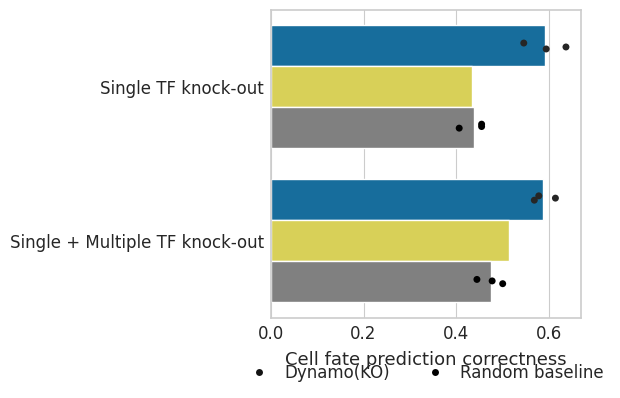

In [47]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(4, 4))

    # Plot the barplot without error bars
    sns.barplot(
        data=df,
        y="Experimental class",
        x="cell fate prediction correctness",
        hue="method",
        hue_order=["RegVelo", "Dynamo (KO)", "Random baseline"],
        palette=METHOD_PALETTE_PERTURBATION,
        ax=ax,
        ci=None,
    )

    # Add jittered dots
    sns.stripplot(
        data=df,
        y="Experimental class",
        x="cell fate prediction correctness",
        hue="method",
        hue_order=["RegVelo", "Dynamo(KO)", "Random baseline"],
        dodge=True,
        color="black",
        ax=ax,
        jitter=True,
    )

    # Remove the duplicate legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles[4 : (4 + len(METHOD_PALETTE_PERTURBATION))],
        labels[4 : (4 + len(METHOD_PALETTE_PERTURBATION))],
        bbox_to_anchor=(0.5, -0.1),
        loc="upper center",
        ncol=2,
    )

    # Customize labels and other settings
    ax.set(ylabel="", xlabel="Cell fate prediction precision")
    ax.set_xlabel(xlabel="Cell fate prediction correctness", fontsize=13)
    # ax.set_xlim(0.45,)

    if SAVE_FIGURES:
        plt.savefig(
            DATA_DIR / DATASET / "results" / "cell_fate_precision.svg",
            format="svg",
            transparent=True,
            bbox_inches="tight",
        )
    plt.show()

## Cell fate prediction Recall

#### Single knock-out panel prediction results

In [48]:
single_matrix = perturbation.loc[single_ko, :]

### Calculate pvalue

In [49]:
pval = pd.read_csv(DATA_DIR / DATASET / "results" / "pval_mat.csv", index_col=0)

In [50]:
pval = pval.loc[single_matrix.index.tolist(), single_matrix.columns.tolist()]

In [51]:
mask_pos = (pval <= 0.05).astype(int)
mask_neg = (pval >= 0.95).astype(int)

In [52]:
single_matrix = mask_neg * (-1) + mask_pos

In [53]:
fate_s = []
method2 = []

In [54]:
coef_KO_dyn = pd.read_csv(DATA_DIR / DATASET / "results" / "dynamo_KO_single.csv", index_col=0)
pval_KO_dyn = pd.read_csv(DATA_DIR / DATASET / "results" / "dynamo_KO_single_pval.csv", index_col=0)
coef_KO_dyn = coef_KO_dyn.loc[single_ko, TERMINAL_STATES_KO]
pval_KO_dyn = pval_KO_dyn.loc[single_ko, TERMINAL_STATES_KO]

pred_m = coef_KO_dyn - 0.5
pred_m_filter = pred_m[pval_KO_dyn < 0.05]
pred_m_filter[np.isnan(pred_m_filter)] = 0

pred_m_filter.columns = single_matrix.columns
score = np.sum(np.sign(single_matrix) * np.sign(pred_m_filter) == 1).sum() / np.sum(single_matrix != 0).sum()

fate_s.append(score)
method2.append("Dynamo (KO)")

In [55]:
for nrun in range(3):
    coef_perturb_rgv = pd.read_csv(
        DATA_DIR / DATASET / "results" / ("runs" + str(nrun + 1)) / "regvelo_single.csv", index_col=0
    )
    pval_perturb_rgv = pd.read_csv(
        DATA_DIR / DATASET / "results" / ("runs" + str(nrun + 1)) / "regvelo_single_pval.csv", index_col=0
    )

    coef_perturb_rgv = coef_perturb_rgv.loc[single_ko, TERMINAL_STATES_KO]
    pval_perturb_rgv = pval_perturb_rgv.loc[single_ko, TERMINAL_STATES_KO]

    pred_m = coef_perturb_rgv
    pred_m_filter = pred_m[pval_perturb_rgv < 0.05]
    pred_m_filter[np.isnan(pred_m_filter)] = 0
    pred_m_filter.columns = single_matrix.columns

    score = np.sum(np.sign(single_matrix) * np.sign(pred_m_filter) == 1).sum() / np.sum(single_matrix != 0).sum()
    fate_s.append(score)
    method2.append("RegVelo")

In [56]:
for nrun in range(3):
    coef_perturb_rgv = pd.read_csv(
        DATA_DIR / DATASET / "results" / ("runs" + str(nrun + 1)) / "regvelo_single.csv", index_col=0
    )
    pval_perturb_rgv = pd.read_csv(
        DATA_DIR / DATASET / "results" / ("runs" + str(nrun + 1)) / "regvelo_single_pval.csv", index_col=0
    )

    coef_perturb_rgv = coef_perturb_rgv.loc[single_ko, TERMINAL_STATES_KO]
    pval_perturb_rgv = pval_perturb_rgv.loc[single_ko, TERMINAL_STATES_KO]

    coef_perturb_rgv = coef_perturb_rgv.sample(frac=1).reset_index(drop=True)
    pval_perturb_rgv = pval_perturb_rgv.sample(frac=1).reset_index(drop=True)

    pred_m = coef_perturb_rgv
    pred_m_filter = pred_m[pval_perturb_rgv < 0.05]
    pred_m_filter[np.isnan(pred_m_filter)] = 0
    pred_m_filter.columns = single_matrix.columns
    pred_m_filter.index = single_matrix.index
    # shuffled = np.random.permutation(pred_m_filter)

    score = np.sum(np.sign(single_matrix) * np.sign(pred_m_filter) == 1).sum() / np.sum(single_matrix != 0).sum()
    fate_s.append(score)
    method2.append("Random baseline")

#### Multiple knock-out panel prediction results

In [57]:
single_matrix = perturbation.loc[single_ko + multiple_ko, :]

In [58]:
pval = pd.read_csv(DATA_DIR / DATASET / "results" / "pval_mat.csv", index_col=0)

In [59]:
pval = pval.loc[single_matrix.index.tolist(), single_matrix.columns.tolist()]

In [60]:
mask_pos = (pval <= 0.05).astype(int)
mask_neg = (pval >= 0.95).astype(int)

In [61]:
single_matrix = mask_neg * (-1) + mask_pos

In [62]:
coef_KO_dyn = pd.read_csv(DATA_DIR / DATASET / "results" / "dynamo_KO_single.csv", index_col=0)
coef_KO_dyn2 = pd.read_csv(DATA_DIR / DATASET / "results" / "dynamo_KO_multiple.csv", index_col=0)

coef_KO_dyn = pd.concat([coef_KO_dyn, coef_KO_dyn2])
coef_KO_dyn = coef_KO_dyn.loc[single_ko + multiple_ko, TERMINAL_STATES_KO]

In [63]:
fate_m = []
method2 = []

pval_KO_dyn = pd.read_csv(DATA_DIR / DATASET / "results" / "dynamo_KO_single_pval.csv", index_col=0)
pval_KO_dyn2 = pd.read_csv(DATA_DIR / DATASET / "results" / "dynamo_KO_multiple_pval.csv", index_col=0)

pval_KO_dyn = pd.concat([pval_KO_dyn, pval_KO_dyn2])
pval_KO_dyn = pval_KO_dyn.loc[single_ko + multiple_ko, TERMINAL_STATES_KO]

pred_m = coef_KO_dyn - 0.5
pred_m_filter = pred_m[pval_KO_dyn <= 0.1]
pred_m_filter[np.isnan(pred_m_filter)] = 0

pred_m_filter.columns = single_matrix.columns
score = np.sum(np.sign(single_matrix) * np.sign(pred_m_filter) == 1).sum() / np.sum(single_matrix != 0).sum()

fate_m.append(score)
method2.append("Dynamo (KO)")

In [64]:
for nrun in range(3):
    coef_perturb_rgv = pd.read_csv(
        DATA_DIR / DATASET / "results" / ("runs" + str(nrun + 1)) / "regvelo_single.csv", index_col=0
    )
    coef_perturb_rgv2 = pd.read_csv(
        DATA_DIR / DATASET / "results" / ("runs" + str(nrun + 1)) / "regvelo_multiple.csv", index_col=0
    )
    coef_perturb_rgv = pd.concat([coef_perturb_rgv, coef_perturb_rgv2])

    pval_perturb_rgv = pd.read_csv(
        DATA_DIR / DATASET / "results" / ("runs" + str(nrun + 1)) / "regvelo_single_pval.csv", index_col=0
    )
    pval_perturb_rgv2 = pd.read_csv(
        DATA_DIR / DATASET / "results" / ("runs" + str(nrun + 1)) / "regvelo_multiple_pval.csv", index_col=0
    )
    pval_perturb_rgv = pd.concat([pval_perturb_rgv, pval_perturb_rgv2])

    coef_perturb_rgv = coef_perturb_rgv.loc[single_ko + multiple_ko, TERMINAL_STATES_KO]
    pval_perturb_rgv = pval_perturb_rgv.loc[single_ko + multiple_ko, TERMINAL_STATES_KO]

    pred_m = coef_perturb_rgv
    pred_m_filter = pred_m[pval_perturb_rgv <= 0.1]
    pred_m_filter[np.isnan(pred_m_filter)] = 0
    pred_m_filter.columns = single_matrix.columns

    score = np.sum(np.sign(single_matrix) * np.sign(pred_m_filter) == 1).sum() / np.sum(single_matrix != 0).sum()
    fate_m.append(score)
    method2.append("RegVelo")

In [65]:
for nrun in range(3):
    coef_perturb_rgv = pd.read_csv(
        DATA_DIR / DATASET / "results" / ("runs" + str(nrun + 1)) / "regvelo_single.csv", index_col=0
    )
    coef_perturb_rgv2 = pd.read_csv(
        DATA_DIR / DATASET / "results" / ("runs" + str(nrun + 1)) / "regvelo_multiple.csv", index_col=0
    )
    coef_perturb_rgv = pd.concat([coef_perturb_rgv, coef_perturb_rgv2])

    pval_perturb_rgv = pd.read_csv(
        DATA_DIR / DATASET / "results" / ("runs" + str(nrun + 1)) / "regvelo_single_pval.csv", index_col=0
    )
    pval_perturb_rgv2 = pd.read_csv(
        DATA_DIR / DATASET / "results" / ("runs" + str(nrun + 1)) / "regvelo_multiple_pval.csv", index_col=0
    )
    pval_perturb_rgv = pd.concat([pval_perturb_rgv, pval_perturb_rgv2])

    coef_perturb_rgv = coef_perturb_rgv.loc[single_ko + multiple_ko, TERMINAL_STATES_KO]
    pval_perturb_rgv = pval_perturb_rgv.loc[single_ko + multiple_ko, TERMINAL_STATES_KO]

    coef_perturb_rgv = coef_perturb_rgv.sample(frac=1).reset_index(drop=True)
    pval_perturb_rgv = pval_perturb_rgv.sample(frac=1).reset_index(drop=True)

    pred_m = coef_perturb_rgv
    pred_m_filter = pred_m[pval_perturb_rgv <= 0.1]
    pred_m_filter[np.isnan(pred_m_filter)] = 0
    pred_m_filter.columns = single_matrix.columns
    pred_m_filter.index = single_matrix.index
    # shuffled = np.random.permutation(pred_m_filter)

    score = np.sum(np.sign(single_matrix) * np.sign(pred_m_filter) == 1).sum() / np.sum(single_matrix != 0).sum()
    fate_m.append(score)
    method2.append("Random baseline")

## Visualize prediction results

In [66]:
dat = pd.DataFrame({"cell fate prediction correctness": fate_s, "method": method2})
dat2 = pd.DataFrame({"cell fate prediction correctness": fate_m, "method": method2})
dat["Experimental class"] = "Single TF knock-out"
dat2["Experimental class"] = "Single + Multiple TF knock-out"
df = pd.concat([dat, dat2], axis=0)

In [67]:
METHOD_PALETTE_PERTURBATION["Random baseline"] = "#808080"

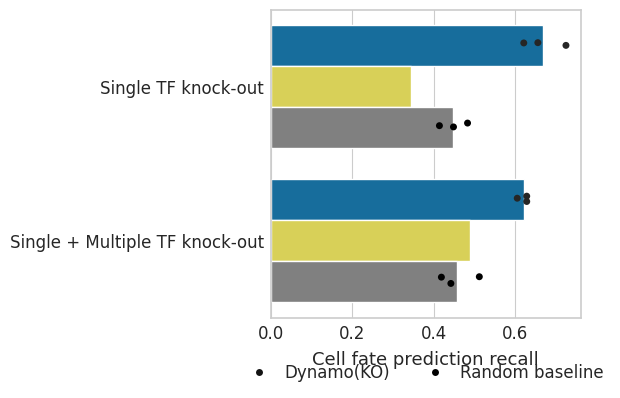

In [68]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(4, 4))

    # Plot the barplot without error bars
    sns.barplot(
        data=df,
        y="Experimental class",
        x="cell fate prediction correctness",
        hue="method",
        hue_order=["RegVelo", "Dynamo (KO)", "Random baseline"],
        palette=METHOD_PALETTE_PERTURBATION,
        ax=ax,
        ci=None,
    )

    # Add jittered dots
    sns.stripplot(
        data=df,
        y="Experimental class",
        x="cell fate prediction correctness",
        hue="method",
        hue_order=["RegVelo", "Dynamo(KO)", "Random baseline"],
        dodge=True,
        color="black",
        ax=ax,
        jitter=True,
    )

    # Remove the duplicate legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles[4 : (4 + len(METHOD_PALETTE_PERTURBATION))],
        labels[4 : (4 + len(METHOD_PALETTE_PERTURBATION))],
        bbox_to_anchor=(0.5, -0.1),
        loc="upper center",
        ncol=2,
    )

    # Customize labels and other settings
    ax.set(ylabel="", xlabel="Cell fate prediction recall")
    ax.set_xlabel(xlabel="Cell fate prediction recall", fontsize=13)
    # ax.set_xlim(0.45,)

    if SAVE_FIGURES:
        plt.savefig(
            DATA_DIR / DATASET / "results" / "cell_fate_recall.svg", format="svg", transparent=True, bbox_inches="tight"
        )
    plt.show()